## Imports

In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from shapely import geometry

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import xskillscore as xs

import som_analysis
import cluster_analysis
import narm_analysis

## functions

In [2]:
def add_insetmap(axes_extent, map_extent, lons, lats, temp_data, 
                 vmin, vmax, cmap='coolwarm'):
    
    use_projection = ccrs.Mercator()     # preserve shape well
    geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))
    
    sub_ax = plt.axes(axes_extent, projection=use_projection)  # normal units
    
    sub_ax.set_extent(map_extent, geodetic)  # map extents
    sub_ax.coastlines(linewidth=0.35, zorder=10)
    
    sub_ax.pcolormesh(lons, lats, temp_data, transform=ccrs.PlateCarree(),
                      vmin=vmin, vmax=vmax, cmap=cmap)

    extent_box = sgeom.box(map_extent[0], map_extent[2], map_extent[1], map_extent[3])
    sub_ax.add_geometries([extent_box], ccrs.PlateCarree(), color='none', linewidth=0.05)

In [3]:
def get_cold_indx(ds, mo_init=9, mo_end=2):
    """
    Extract indices for cold season.
    Grabbing Sept thru February init, for Oct thru March predictions.
    """
    dt_array = pd.to_datetime(ds['time'])
    return xr.where((dt_array.month>=mo_init) | (dt_array.month<=mo_end), True, False)

## open and preprocess training data -- main ERA5 data

In [4]:
# region for clustering
lat0=10; lat1=70; lon0=-150; lon1=-40

# open era5 data and slice
ds_era5 = narm_analysis.era5_z500(lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1)

# era5 anomalies
ds_era5_anom = narm_analysis.era5_climo_wrs(ds_era5, rolling_days=5, variable='clim')

# restructure era5 array for machine learning training (SONDJFM)
ds_era5_anom = ds_era5_anom[get_cold_indx(ds_era5_anom, mo_init=10, mo_end=3),...]
ds_era5_train = ds_era5_anom.stack(flat=('lat','lon')).transpose('time','flat').values

## pca and kmeans with era5

In [5]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(ds_era5_train)

# transform era5 data with pca
ds_era5_train = pca_obj.transform(ds_era5_train)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}'
)

# train kmeans
k_means = KMeans(n_clusters=4,
                 init='k-means++',
                 n_init=10000,
                 max_iter=300,
                 tol=0.0001,
                 verbose=0,
                 random_state=0).fit(ds_era5_train)

print(f'inertia: {k_means.inertia_}')

Variance explained: [25.95315607 17.65410568 11.94871708  9.0784389   7.98100848  6.14181738
  4.32605934  2.61658689  2.22642929  2.17049559  1.49813958  1.22541708]
Cumulative sum of variance explained for EOF1 and EOF2: [25.95315607 43.60726175 55.55597883 64.63441774 72.61542622 78.7572436
 83.08330294 85.69988983 87.92631912 90.09681471 91.59495429 92.82037136]
inertia: 39379.205334200386


## open data for clustering

## era5

In [6]:
lat0=10; lat1=70; lon0=-150; lon1=-40

# era5 data

z500_era5, z500_era5_dt = som_analysis.open_era5_files(
    variable='z500', return_time=True, 
    lat0=lat0,lat1=lat1,lon0=lon0,lon1=lon1,
    leadday0=0,leadday1=42,rolldays=5,)

z500_standard_era5 = z500_era5.stack(
    new=('time','lead'),flat=('lat','lon')).transpose('new','flat')

In [7]:
# grab cluster indices

z500_era5_tmp_1, z500_era5_tmp_2, z500_era5_tmp_3, z500_era5_tmp_4 = cluster_analysis.composite_clusters_indx(
    z500_standard_era5, k_means, pca_obj, use_pca=True)

## cesm ensembles

In [8]:
# cesm data

z500_cesm, z500_cesm_dt, z500_cesm_ens = som_analysis.open_cesm_ensembles(
    variable='zg_500', return_time=True, 
    lat0=lat0,lat1=lat1,lon0=lon0,lon1=lon1,
    leadday0=0,leadday1=42,rolldays=5,)

In [9]:
z500_standard_cesm = z500_cesm.stack(
    new=('ensemble','time','lead'),flat=('lat','lon')).transpose('new','flat')

In [10]:
# grab cluster indices

z500_cesm_tmp_1, z500_cesm_tmp_2, z500_cesm_tmp_3, z500_cesm_tmp_4 = cluster_analysis.composite_clusters_indx(
    z500_standard_cesm, k_means, pca_obj, use_pca=True)

## open northern hemisphere era5 and cesm

In [11]:
# era5 data
z500_era5_tmp, _ = som_analysis.open_era5_files(variable='z500', return_time=True, 
                                                lat0=10,lat1=90,lon0=-360,lon1=0,
                                                leadday0=0,leadday1=42,rolldays=5)

In [12]:
# cesm data
z500_cesm_tmp, _, _ = som_analysis.open_cesm_ensembles(
                                                variable='zg_500', return_time=True, 
                                                lat0=10,lat1=90,lon0=-360,lon1=0,
                                                leadday0=0,leadday1=42,rolldays=5)

In [13]:
# restructure data array
z500_standard_era5_tmp = z500_era5_tmp.stack(
    new=('time','lead'),flat=('lat','lon')).transpose('new','flat')

z500_standard_cesm_tmp = z500_cesm_tmp.stack(
    new=('ensemble','time','lead'),flat=('lat','lon')).transpose('new','flat')

In [14]:
wr1_era5 = z500_standard_era5_tmp.unstack('flat')[z500_era5_tmp_1,:,:].mean('new',skipna=True)
wr2_era5 = z500_standard_era5_tmp.unstack('flat')[z500_era5_tmp_2,:,:].mean('new',skipna=True)
wr3_era5 = z500_standard_era5_tmp.unstack('flat')[z500_era5_tmp_3,:,:].mean('new',skipna=True)
wr4_era5 = z500_standard_era5_tmp.unstack('flat')[z500_era5_tmp_4,:,:].mean('new',skipna=True)

In [15]:
wr1_cesm = z500_standard_cesm_tmp.unstack('flat')[z500_cesm_tmp_1,:,:].mean('new',skipna=True)
wr2_cesm = z500_standard_cesm_tmp.unstack('flat')[z500_cesm_tmp_2,:,:].mean('new',skipna=True)
wr3_cesm = z500_standard_cesm_tmp.unstack('flat')[z500_cesm_tmp_3,:,:].mean('new',skipna=True)
wr4_cesm = z500_standard_cesm_tmp.unstack('flat')[z500_cesm_tmp_4,:,:].mean('new',skipna=True)

/glade/scratch/molina/ipykernel_223460/4267940838.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


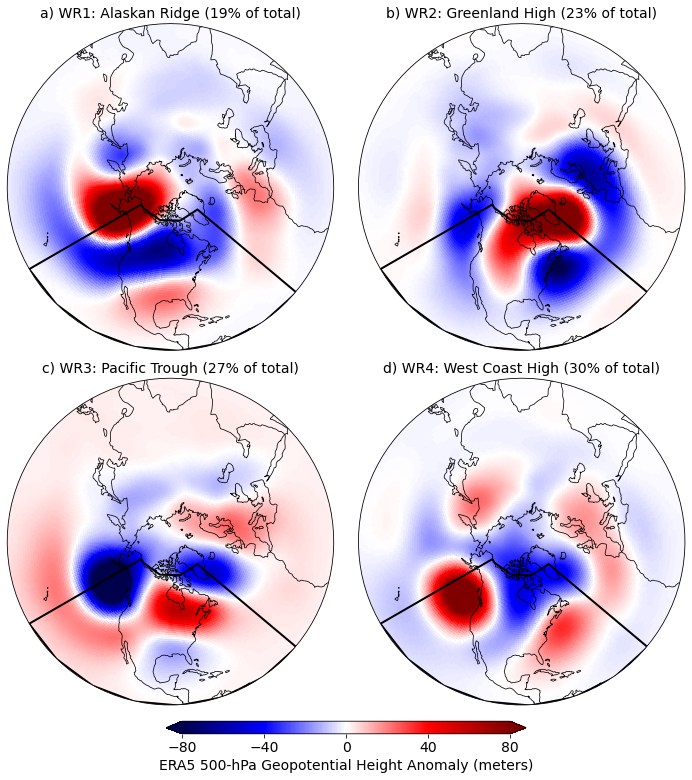

In [16]:
total = z500_era5_tmp_1.shape[0] + z500_era5_tmp_2.shape[0] + z500_era5_tmp_3.shape[0] + z500_era5_tmp_4.shape[0]
lons, lats = np.meshgrid(wr1_era5.lon, wr1_era5.lat)

# ---

fig, axs = plt.subplots(
    2, 2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-90)),
    figsize=(10, 10))

# ---

axs[0][0].pcolormesh(lons, lats, wr1_era5.values,
                     transform=ccrs.PlateCarree(),
                     vmin=-80, vmax=80, cmap='seismic')

axs[0][0].set_title(
    f'a) WR1: Alaskan Ridge ({int(np.around((z500_era5_tmp_1.shape[0] / total) * 100))}% of total)', 
    fontsize=14)

axs[0][0].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[0][0].margins(x=0, y=0)

axs[0][0].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[0][0].set_boundary(circle, transform=axs[0][0].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[0][0].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

axs[0][1].pcolormesh(lons, lats, wr2_era5.values,
                     transform=ccrs.PlateCarree(), 
                     vmin=-80, vmax=80, cmap='seismic')

axs[0][1].set_title(
    f'b) WR2: Greenland High ({int(np.around((z500_era5_tmp_2.shape[0] / total) * 100))}% of total)', 
    fontsize=14)

axs[0][1].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[0][1].margins(x=0, y=0)

axs[0][1].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[0][1].set_boundary(circle, transform=axs[0][1].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[0][1].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

axs[1][0].pcolormesh(lons, lats, wr3_era5.values,
                     transform=ccrs.PlateCarree(),
                     vmin=-80, vmax=80, cmap='seismic')

axs[1][0].set_title(
    f'c) WR3: Pacific Trough ({int(np.around((z500_era5_tmp_3.shape[0] / total) * 100))}% of total)', 
    fontsize=14)

axs[1][0].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[1][0].margins(x=0, y=0)

axs[1][0].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[1][0].set_boundary(circle, transform=axs[1][0].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[1][0].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

pm = axs[1][1].pcolormesh(lons, lats, wr4_era5.values,
                          transform=ccrs.PlateCarree(),
                          vmin=-80, vmax=80, cmap='seismic')

axs[1][1].set_title(
    f'd) WR4: West Coast High ({int(np.around((z500_era5_tmp_4.shape[0] / total) * 100))}% of total)', 
    fontsize=14)

axs[1][1].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[1][1].margins(x=0,y=0)

axs[1][1].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[1][1].set_boundary(circle, transform=axs[1][1].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[1][1].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

cbar_ax = fig.add_axes([0.25, -0.025, 0.5, 0.0175])

ticks_1 = [-80, -40, 0, 40, 80]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'ERA5 500-hPa Geopotential Height Anomaly (meters)', fontsize=14)

# ---

plt.tight_layout()
# plt.savefig("fig1_wr_era5.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

/glade/scratch/molina/ipykernel_223460/1147452092.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


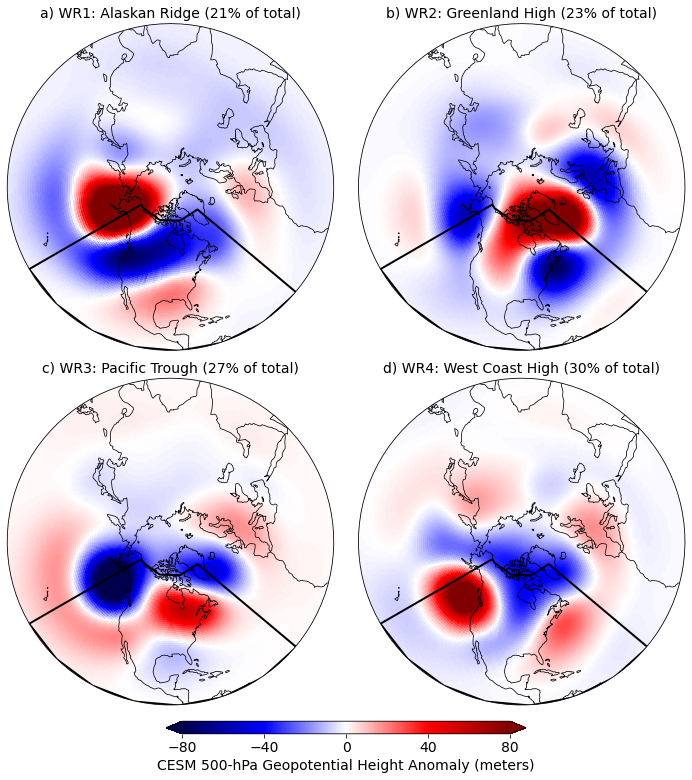

In [17]:
total = z500_cesm_tmp_1.shape[0] + z500_cesm_tmp_2.shape[0] + z500_cesm_tmp_3.shape[0] + z500_cesm_tmp_4.shape[0]
lons, lats = np.meshgrid(wr1_cesm.lon, wr1_cesm.lat)

# ---

fig, axs = plt.subplots(
    2, 2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-90)),
    figsize=(10, 10))

# ---

axs[0][0].pcolormesh(lons, lats, wr1_cesm.values,
                     transform=ccrs.PlateCarree(),
                     vmin=-80, vmax=80, cmap='seismic')

axs[0][0].set_title(
    f'a) WR1: Alaskan Ridge ({int(np.around((z500_cesm_tmp_1.shape[0] / total) * 100))}% of total)', 
    fontsize=14)

axs[0][0].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[0][0].margins(x=0, y=0)

axs[0][0].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[0][0].set_boundary(circle, transform=axs[0][0].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[0][0].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

axs[0][1].pcolormesh(lons, lats, wr2_cesm.values,
                     transform=ccrs.PlateCarree(), 
                     vmin=-80, vmax=80, cmap='seismic')

axs[0][1].set_title(
    f'b) WR2: Greenland High ({int(np.around((z500_cesm_tmp_2.shape[0] / total) * 100))}% of total)', 
    fontsize=14)

axs[0][1].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[0][1].margins(x=0, y=0)

axs[0][1].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[0][1].set_boundary(circle, transform=axs[0][1].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[0][1].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

axs[1][0].pcolormesh(lons, lats, wr3_cesm.values,
                     transform=ccrs.PlateCarree(),
                     vmin=-80, vmax=80, cmap='seismic')

axs[1][0].set_title(
    f'c) WR3: Pacific Trough ({int(np.around((z500_cesm_tmp_3.shape[0] / total) * 100))}% of total)', 
    fontsize=14)

axs[1][0].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[1][0].margins(x=0, y=0)

axs[1][0].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[1][0].set_boundary(circle, transform=axs[1][0].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[1][0].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

pm = axs[1][1].pcolormesh(lons, lats, wr4_cesm.values,
                          transform=ccrs.PlateCarree(),
                          vmin=-80, vmax=80, cmap='seismic')

axs[1][1].set_title(
    f'd) WR4: West Coast High ({int(np.around((z500_cesm_tmp_4.shape[0] / total) * 100))}% of total)', 
    fontsize=14)

axs[1][1].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[1][1].margins(x=0,y=0)

axs[1][1].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[1][1].set_boundary(circle, transform=axs[1][1].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[1][1].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

cbar_ax = fig.add_axes([0.25, -0.025, 0.5, 0.0175])

ticks_1 = [-80, -40, 0, 40, 80]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'CESM 500-hPa Geopotential Height Anomaly (meters)', fontsize=14)

# ---

plt.tight_layout()
# plt.savefig("fig1_wr_era5.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

## train k-means with cesm (era5-pca)

In [18]:
z500_cesm_train = z500_cesm.stack(
    new=('time','lead','ensemble'),flat=('lat','lon')).transpose('new','flat').values

In [19]:
# transform cesm data with pca
z500_cesm_train2 = pca_obj.transform(z500_cesm_train)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}'
)

# train kmeans
k_means_2 = KMeans(n_clusters=4,
                 init='k-means++',
                 n_init=10000,
                 max_iter=300,
                 tol=0.0001,
                 verbose=0,
                 random_state=0).fit(z500_cesm_train2)

print(f'inertia: {k_means_2.inertia_}')

Variance explained: [25.95315607 17.65410568 11.94871708  9.0784389   7.98100848  6.14181738
  4.32605934  2.61658689  2.22642929  2.17049559  1.49813958  1.22541708]
Cumulative sum of variance explained for EOF1 and EOF2: [25.95315607 43.60726175 55.55597883 64.63441774 72.61542622 78.7572436
 83.08330294 85.69988983 87.92631912 90.09681471 91.59495429 92.82037136]
inertia: 2688458.799163429


In [20]:
# grab cluster indices

z500_cesm_tmp2_1, z500_cesm_tmp2_2, z500_cesm_tmp2_3, z500_cesm_tmp2_4 = cluster_analysis.composite_clusters_indx(
    z500_standard_cesm, k_means_2, pca_obj, use_pca=True)

In [21]:
wr1_cesm2 = z500_standard_cesm_tmp.unstack('flat')[z500_cesm_tmp2_1,:,:].mean('new',skipna=True)
wr2_cesm2 = z500_standard_cesm_tmp.unstack('flat')[z500_cesm_tmp2_2,:,:].mean('new',skipna=True)
wr3_cesm2 = z500_standard_cesm_tmp.unstack('flat')[z500_cesm_tmp2_3,:,:].mean('new',skipna=True)
wr4_cesm2 = z500_standard_cesm_tmp.unstack('flat')[z500_cesm_tmp2_4,:,:].mean('new',skipna=True)

/glade/scratch/molina/ipykernel_223460/3216071261.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


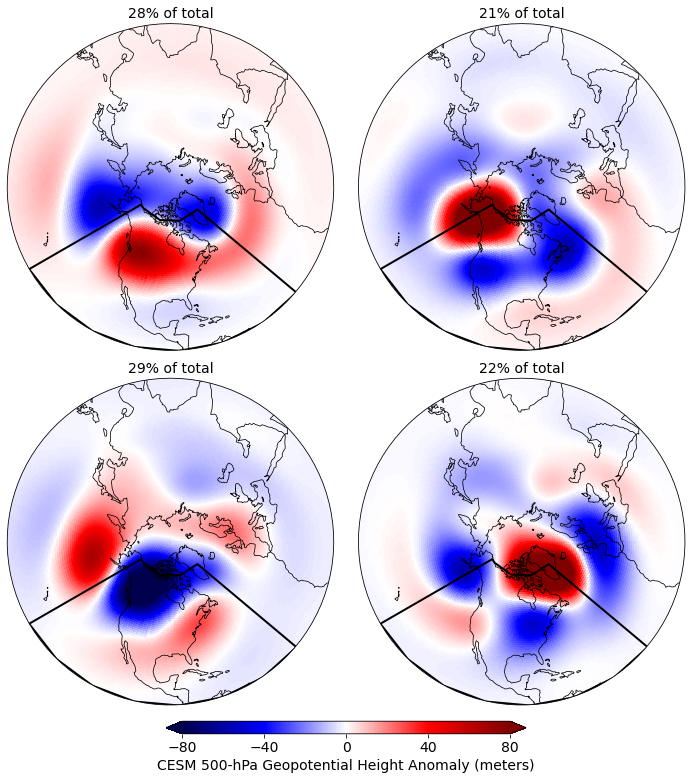

In [23]:
total = z500_cesm_tmp2_1.shape[0] + z500_cesm_tmp2_2.shape[0] + z500_cesm_tmp2_3.shape[0] + z500_cesm_tmp2_4.shape[0]
lons, lats = np.meshgrid(wr1_cesm2.lon, wr1_cesm2.lat)

# ---

fig, axs = plt.subplots(
    2, 2,
    subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-90)),
    figsize=(10, 10))

# ---

axs[0][0].pcolormesh(lons, lats, wr1_cesm2.values,
                     transform=ccrs.PlateCarree(),
                     vmin=-80, vmax=80, cmap='seismic')

axs[0][0].set_title(
    f'{int(np.around((z500_cesm_tmp2_1.shape[0] / total) * 100))}% of total', 
    fontsize=14)

axs[0][0].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[0][0].margins(x=0, y=0)

axs[0][0].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[0][0].set_boundary(circle, transform=axs[0][0].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[0][0].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

axs[0][1].pcolormesh(lons, lats, wr2_cesm2.values,
                     transform=ccrs.PlateCarree(), 
                     vmin=-80, vmax=80, cmap='seismic')

axs[0][1].set_title(
    f'{int(np.around((z500_cesm_tmp2_2.shape[0] / total) * 100))}% of total', 
    fontsize=14)

axs[0][1].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[0][1].margins(x=0, y=0)

axs[0][1].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[0][1].set_boundary(circle, transform=axs[0][1].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[0][1].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

axs[1][0].pcolormesh(lons, lats, wr3_cesm2.values,
                     transform=ccrs.PlateCarree(),
                     vmin=-80, vmax=80, cmap='seismic')

axs[1][0].set_title(
    f'{int(np.around((z500_cesm_tmp2_3.shape[0] / total) * 100))}% of total', 
    fontsize=14)

axs[1][0].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[1][0].margins(x=0, y=0)

axs[1][0].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[1][0].set_boundary(circle, transform=axs[1][0].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[1][0].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

pm = axs[1][1].pcolormesh(lons, lats, wr4_cesm2.values,
                          transform=ccrs.PlateCarree(),
                          vmin=-80, vmax=80, cmap='seismic')

axs[1][1].set_title(
    f'{int(np.around((z500_cesm_tmp2_4.shape[0] / total) * 100))}% of total', 
    fontsize=14)

axs[1][1].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs[1][1].margins(x=0,y=0)

axs[1][1].set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs[1][1].set_boundary(circle, transform=axs[1][1].transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs[1][1].add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

# ---

cbar_ax = fig.add_axes([0.25, -0.025, 0.5, 0.0175])

ticks_1 = [-80, -40, 0, 40, 80]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'CESM 500-hPa Geopotential Height Anomaly (meters)', fontsize=14)

# ---

plt.tight_layout()
# plt.savefig("fig1_wr_era5.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

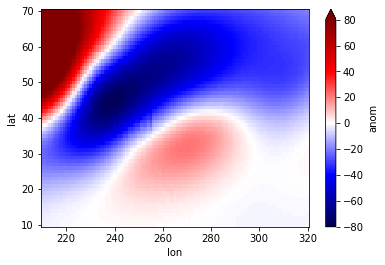

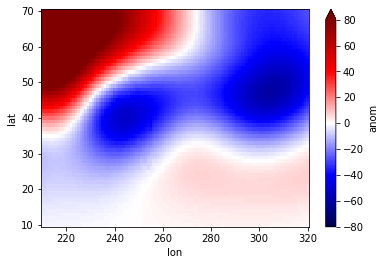

In [71]:
wr1_cesm.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).plot.pcolormesh(
    vmin=-80,vmax=80,cmap='seismic'); plt.show()

wr2_cesm2.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).plot.pcolormesh(
    vmin=-80,vmax=80,cmap='seismic'); plt.show()

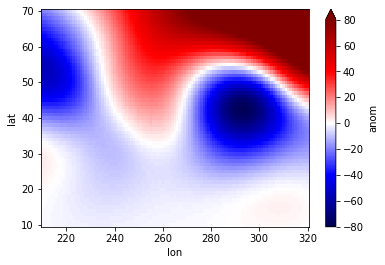

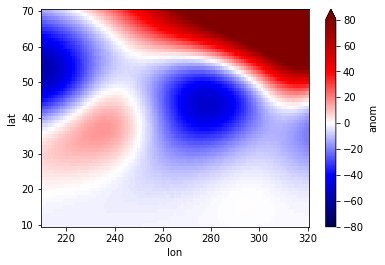

In [72]:
wr2_cesm.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).plot.pcolormesh(
    vmin=-80,vmax=80,cmap='seismic'); plt.show()

wr4_cesm2.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).plot.pcolormesh(
    vmin=-80,vmax=80,cmap='seismic'); plt.show()

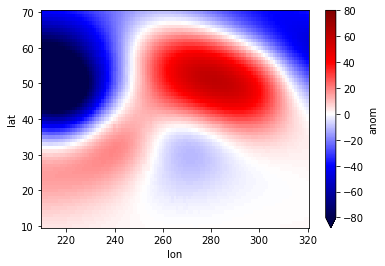

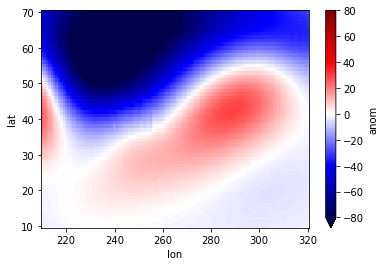

In [73]:
wr3_cesm.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).plot.pcolormesh(
    vmin=-80,vmax=80,cmap='seismic'); plt.show()

wr3_cesm2.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).plot.pcolormesh(
    vmin=-80,vmax=80,cmap='seismic'); plt.show()

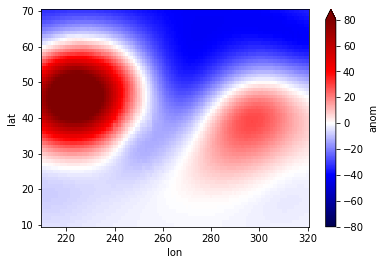

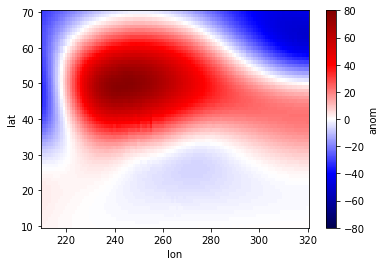

In [74]:
wr4_cesm.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).plot.pcolormesh(
    vmin=-80,vmax=80,cmap='seismic'); plt.show()

wr1_cesm2.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).plot.pcolormesh(
    vmin=-80,vmax=80,cmap='seismic'); plt.show()

In [65]:
stats.pearsonr(wr1_cesm.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).stack(tmp=('lat','lon')),
               wr2_cesm2.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).stack(tmp=('lat','lon')))

(0.736515805033408, 0.0)

In [63]:
stats.pearsonr(wr2_cesm.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).stack(tmp=('lat','lon')),
               wr4_cesm2.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).stack(tmp=('lat','lon')))

(0.8886243447777085, 0.0)

In [70]:
stats.pearsonr(wr3_cesm.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).stack(tmp=('lat','lon')),
               wr3_cesm2.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).stack(tmp=('lat','lon')))

(0.3922689708434658, 6.237025431523388e-248)

In [51]:
stats.pearsonr(wr4_cesm.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).stack(tmp=('lat','lon')),
               wr1_cesm2.sel(lat=slice(10,70),lon=slice(-150+360,-40+360)).stack(tmp=('lat','lon')))

(0.27268057950770497, 9.593233024089136e-116)

In [12]:
# train kmeans on era5 because:
# 1-- we don't have all days in cesm -- initialized on mondays, thus, incomplete climo
# 2-- training kmeans on cesm data does not allow us to assess whether the weather regime 
# was correctly predicted on that day since we don't have the corresponding weather regime from observations